In [1]:
# Import libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)

In [10]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [89]:
# Find the most recent date in the data set.
first_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'The most recent date in the data set is: {first_date}')

The most recent date in the data set is: ('2017-08-23',)


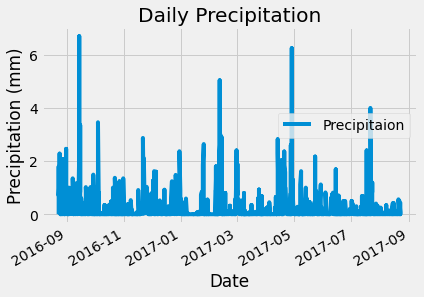

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set
# Perform a query to retrieve the data and precipitation scores
months_12 = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date > '2016-08-22').\
                    order_by(Measurement.date).\
                    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(months_12, columns = ['Date', 'Precipitation'])
prcp_df['Date'] = pd.to_datetime(prcp_df['Date'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("Date").dropna().set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title='Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitaion
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(Station).count()
print(f"Number of Stations: {stations_count}")

Number of Stations: 9


In [53]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, Station.name, func.count(Measurement.id)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.id).desc()).all()
print(f"Most active stations are: ")
most_active

Most active stations are: 


[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [79]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_temp = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),
                                func.avg(Measurement.tobs)).\
                                filter(Measurement.station == most_active[0][0]).all()

print(f"The most active station: {most_active_temp[0][0]}")
print(f"Lowest Temperature: {most_active_temp[0][1]}")
print(f"Highest Temperature: {most_active_temp[0][2]}")
print(f"Average Temperature: {most_active_temp[0][3]}")

The most active station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


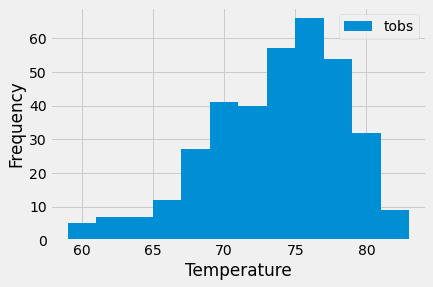

In [87]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_months_12 = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.date > '2016-08-17').\
                    filter(most_active_temp[0][0] == Measurement.station).\
                    order_by(Measurement.date).\
                    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
active_df = pd.DataFrame(active_months_12, columns = ['Date', 'tobs'])
active_df['Date'] = pd.to_datetime(active_df['Date'])

# Sort the dataframe by date
active_df = active_df.sort_values("Date").dropna().set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data
active_df.plot(kind='hist', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [88]:
# Close Session
session.close()